In [225]:
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import functools
import torchvision.models as models
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from skimage import io, transform
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [204]:
torchvision.__version__

'0.8.1'

In [205]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4,5,6,7'

In [207]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [208]:
'''Data Preprocessing'''
    
def read_image(image):
        
        image = np.array(image)
        width = image.shape[1]
        width_half = width // 2
       
        input_image = image[:, :width_half, :]
        target_image = image[:, width_half:, :]
    
        input_image = input_image.astype(np.float32)
        target_image = target_image.astype(np.float32)
    
        return input_image, target_image

def random_crop(image, dim):
    height, width, _ = dim
    rand_crop = np.random.uniform(low=0,high=256)
    x, y = np.random.uniform(low=0,high=int(height-256)), np.random.uniform(low=0,high=int(width-256))  
    #return print(image.shape)
    return image[:, int(x):int(x)+256, int(y):int(y)+256]

    

def random_jittering_mirroring(input_image, target_image, height=286, width=286):
    
    #resizing to 286x286
    input_image = cv2.resize(input_image, (height, width) ,interpolation=cv2.INTER_NEAREST)
    target_image = cv2.resize(target_image, (height, width),
                               interpolation=cv2.INTER_NEAREST)
    
    #print(input_image.shape)
    #cropping (random jittering) to 256x256
    stacked_image = np.stack([input_image, target_image], axis=0)
    cropped_image = random_crop(stacked_image, dim=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    input_image, target_image = cropped_image[0], cropped_image[1]
    #print(input_image.shape)
    if torch.rand(()) > 0.5:
     # random mirroring
        input_image = np.fliplr(input_image)
        target_image = np.fliplr(target_image)
    return input_image, target_image
        
def normalize(inp, tar):
    input_image = (inp / 127.5) - 1
    target_image = (tar / 127.5) - 1
    return input_image, target_image
        
class Train_Normalize(object):
    def __call__(self, image):
        inp, tar = read_image(image)
        inp, tar = random_jittering_mirroring(inp, tar)
        inp, tar = normalize(inp, tar)
        image_a = torch.from_numpy(inp.copy().transpose((2,0,1)))
        image_b = torch.from_numpy(tar.copy().transpose((2,0,1)))
        return image_a, image_b    
    
class Val_Normalize(object):
    def __call__(self, image):
        inp, tar = read_image(image)
        #inp, tar = random_jittering_mirroring(inp, tar)
        inp, tar = normalize(inp, tar)
        image_a = torch.from_numpy(inp.copy().transpose((2,0,1)))
        image_b = torch.from_numpy(tar.copy().transpose((2,0,1)))
        return image_a, image_b

In [209]:
DIR = 'edges2shoes/train_data/'
n_gpus = 4
batch_size = 64 * n_gpus

train_ds = ImageFolder(DIR, transform=transforms.Compose([
        Train_Normalize()]))
train_dl = DataLoader(train_ds, batch_size)

In [211]:
VAL_DIR = 'edges2shoes/val_data/'

batch_size = 64 * n_gpus

val_ds = ImageFolder(VAL_DIR, transform=transforms.Compose([
        Val_Normalize()]))
val_dl = DataLoader(val_ds, batch_size)

In [16]:
def imshow(inputs, target, figsize=(10, 5)):
    inputs = np.uint8(inputs)
    target = np.uint8(target)
    tar = np.rollaxis(target[0], 0, 3)
    inp = np.rollaxis(inputs[0], 0, 3)
    title = ['Input Image', 'Ground Truth']
    display_list = [inp, tar]
    plt.figure(figsize=figsize)
  
    for i in range(2):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.axis('off')
        plt.imshow(display_list[i])
    plt.axis('off')
 
    #plt.imshow(image)    

def show_batch(dl):
    j=0
    for (images_a, images_b), _ in dl:
        j += 1
        imshow(images_a, images_b)
        if j == 3:
            break

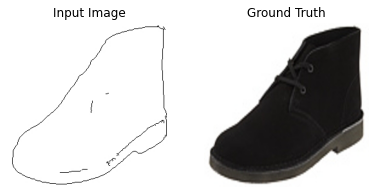

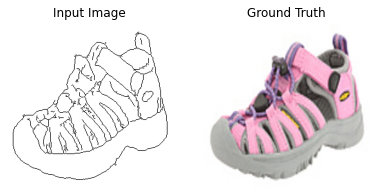

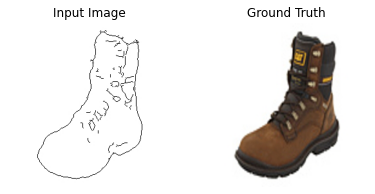

In [17]:
show_batch(train_dl)

In [216]:
# custom weights initialization called on generator and discriminator        
def init_weights(net, init_type='normal', scaling=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


In [218]:
def get_norm_layer(norm_type='instance'):
    """Return a normalization layer
    Parameters:
        norm_type (str) -- the name of the normalization layer: batch | instance | none
    For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    """
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    return norm_layer

In [219]:
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, nf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            nf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        
        # add intermediate layers with ngf * 8 filters
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        
        # gradually reduce the number of filters from nf * 8 to nf
        unet_block = UnetSkipConnectionBlock(nf * 4, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf * 2, nf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf, nf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, nf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

In [220]:
class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

In [228]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [229]:
torch.cuda.device_count()

1

In [230]:
generator = UnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False)#.cuda().float()
generator.apply(weights_init)

generator = torch.nn.DataParallel(generator)  # multi-GPUs

In [231]:
#generator

In [232]:
inp = torch.ones(1, 3,256,256)
#gen = generator(inp)
device = 'cuda'
inp = inp.to(device)
generator = generator.to(device)

In [233]:
print(summary(generator,(3,256,256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       4,194,304
      BatchNorm2d-13            [-1, 512, 8, 8]           1,024
        LeakyReLU-14            [-1, 51

In [236]:
class Discriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(Discriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw), nn.Sigmoid()]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [237]:
discriminator = Discriminator(6, 64, n_layers=3, norm_layer=norm_layer)#.cuda().float()
discriminator.apply(weights_init)
discriminator = torch.nn.DataParallel(discriminator)  # multi-GPUs

In [238]:
inp = torch.ones(1,6,256,256)
disc = discriminator(inp)
# device = 'cuda'
# inp = inp.to(device)
# discriminator = discriminator.to(device)

In [239]:
summary(discriminator,(6,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,208
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,152
      BatchNorm2d-10          [-1, 512, 31, 31]           1,024
        LeakyReLU-11          [-1, 512, 31, 31]               0
           Conv2d-12            [-1, 1, 30, 30]           8,193
          Sigmoid-13            [-1, 1, 30, 30]               0
    Discriminator-14            [-1, 1,

In [25]:
adversarial_loss = nn.BCELoss() 
l1_loss = nn.L1Loss()

In [27]:
def generator_loss(generated_image, target_img, G, real_target):
    gen_loss = adversarial_loss(G, real_target)
    l1_l = l1_loss(generated_image, target_img)
    gen_total_loss = gen_loss + (100 * l1_l)
    #print(gen_loss)
    return gen_total_loss

In [28]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [29]:
learning_rate = 2e-4 
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

In [240]:
num_epochs = 200
D_loss_plot, G_loss_plot = [], []
for epoch in range(1, num_epochs+1): 
  

    D_loss_list, G_loss_list = [], []
   
    for (input_img, target_img), _ in train_dl:
       
        D_optimizer.zero_grad()
        input_img = input_img.to(device)
        target_img = target_img.to(device)
        
#         print("Inp:",input_img.shape)
#         print("Tar:", target_img.shape)
        
        generated_image = generator(input_img)
        
        disc_inp_fake = torch.cat((input_img, generated_image), 1)
       
        
        
        real_target = Variable(torch.ones(input_img.size(0), 1, 30, 30).to(device))
        fake_target = Variable(torch.zeros(input_img.size(0), 1, 30, 30).to(device))
        
#         print("Fake_targ:",fake_target.shape)
        D_fake = discriminator(disc_inp_fake.detach())
        
#         print("D_fake:",D_fake.shape)
        D_fake_loss   =  discriminator_loss(D_fake, fake_target)
        # print(discriminator(real_images))
        #D_real_loss.backward()
    
        disc_inp_real = torch.cat((input_img, target_img), 1)
        
                                         
        output = discriminator(disc_inp_real)
        D_real_loss = discriminator_loss(output,  real_target)

    
        # train with fake
        #D_fake_loss.backward()
      
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
      
        D_total_loss.backward()
        D_optimizer.step()
        
        
        # Train generator with real labels
        G_optimizer.zero_grad()
        fake_gen = torch.cat((input_img, generated_image), 1)
#         print('fake_gen:', fake_gen)
        G = discriminator(fake_gen)
        G_loss = generator_loss(generated_image, target_img, G, real_target)                                 
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()
        
    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
             torch.mean(torch.FloatTensor(G_loss_list))))
    
    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))
     
    torch.save(generator.state_dict(), 'torch/training_weights/generator_epoch_%d.pth' % (epoch))
    torch.save(discriminator.state_dict(), 'torch/training_weights/discriminator_epoch_%d.pth' % (epoch))
    
    for (inputs, targets), _ in val_dl:
        inputs = inputs.to(device)
        generated_output = generator(inputs)
        save_image(generated_output.data[:10], 'torch/images/sample_%d'%epoch + '.png', nrow=5, normalize=True)
  